In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, BisectingKMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

from pyclustering.cluster import xmeans

In [2]:
df = pd.read_csv("./dataset (missing + split)/processed.csv", skipinitialspace=True)

In [3]:
cat = ['name','explicit','artists','album_name','key','mode','time_signature','genre']
num = [col for col in df.columns if col not in cat] #list comprehension

Tutte le variabili numeriche vengono normalizzate prima di eseguire gli algoritmi di clustering. I valori vengono mappati al range [0,1]

In [4]:
X = df[num].values

minmaxscaler = MinMaxScaler()
X_minmax = minmaxscaler.fit_transform(X)

# Analysis by centroid-based methods

### K-means

Si cerca il valore di k migliore controllando i valori di SSE e silhouette coefficient per ogni valore:

In [5]:
%%time

sse_list = []
sil_list = []
dist = squareform(pdist(X_minmax)) # using a precomputed distance matrix

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(dist, kmeans.labels_, metric='precomputed'))

CPU times: user 4min 2s, sys: 40.6 s, total: 4min 43s
Wall time: 1min 11s


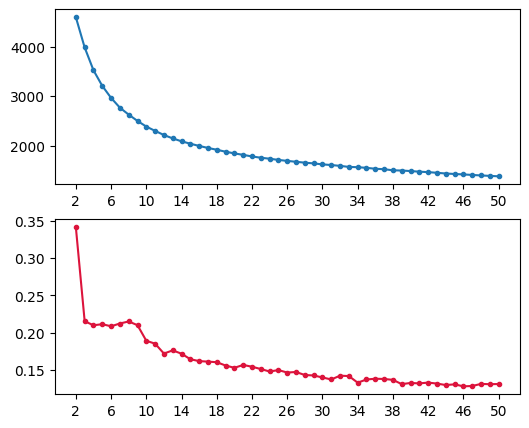

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6,5)) 

ax1.plot(np.arange(2,51), sse_list, marker='.')
ax1.set_xticks(np.arange(2,51,4))

ax2.plot(np.arange(2,51), sil_list, marker='.', color='crimson')
ax2.set_xticks(np.arange(2,51,4))

plt.savefig(fname='img/clustering_kmeans_SSE_and_Silhouette.png', dpi=300, bbox_inches='tight')

plt.show()

Iperparametro ideale con cui eseguire K-means: k=6

In [7]:
k = 6

In [8]:
kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=94)
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=6, n_init=10, random_state=94)

In [9]:
# Numero di punti per cluster

labels, counts = np.unique(kmeans.labels_, return_counts=True)
for l, c in zip(labels,counts):
    print('Cluster ', l, ': ', c)
print('Silhouette: ', silhouette_score(X_minmax, kmeans.labels_))
print('SSE: ', kmeans.inertia_)

Cluster  0 :  2676
Cluster  1 :  4438
Cluster  2 :  1602
Cluster  3 :  2923
Cluster  4 :  1484
Cluster  5 :  1827
Silhouette:  0.20869487814376927
SSE:  2967.0463955691753


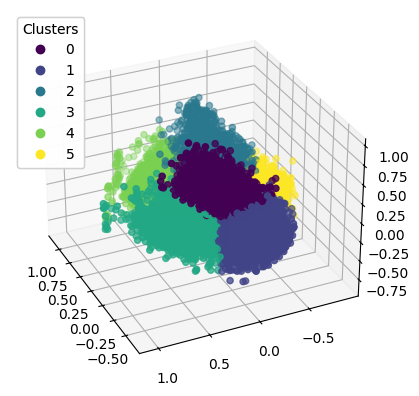

'df_2d = pca.fit_transform(X_minmax)  # Reduce the data to two dimensions using the PCA model\n\nfig = px.scatter(x=df_2d[:, 0], y=df_2d[:, 1], color=kmeans.labels_)\nfig.update_layout(\n    title="PCA visualization of Custom Classification dataset",\n    xaxis_title="First Principal Component",\n    yaxis_title="Second Principal Component",\n)\n\nplt.savefig(fname=\'img/ciao.png\')\nfig.show()'

In [10]:
pca = PCA(n_components=3)  # Initialize a PCA model with 2 components
pca_data = pd.DataFrame(pca.fit_transform(X_minmax),columns=['PC1','PC2','PC3'])
pca_data['cluster'] = pd.Categorical(kmeans.labels_)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(pca_data['PC1'],pca_data['PC2'],pca_data['PC3'],c=pca_data['cluster'])
ax.add_artist(ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters"))
ax.view_init(elev=30., azim=155)


plt.savefig(fname='img/PCA_kmeans.png', dpi=300, bbox_inches='tight')
plt.show()

'''df_2d = pca.fit_transform(X_minmax)  # Reduce the data to two dimensions using the PCA model

fig = px.scatter(x=df_2d[:, 0], y=df_2d[:, 1], color=kmeans.labels_)
fig.update_layout(
    title="PCA visualization of Custom Classification dataset",
    xaxis_title="First Principal Component",
    yaxis_title="Second Principal Component",
)

plt.savefig(fname='img/ciao.png')
fig.show()'''

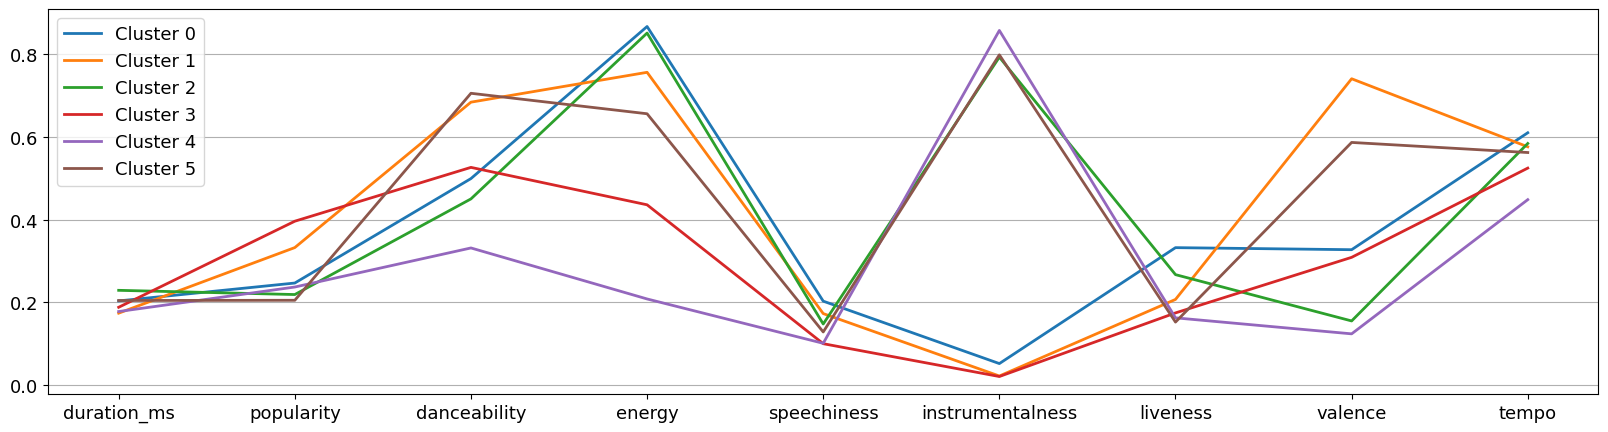

In [12]:
plt.figure(figsize=(20, 5))
centers = kmeans.cluster_centers_
for i in range(len(centers)):
    plt.plot(range(0, 9), centers[i], label='Cluster %s' % i, linewidth=2)
    
plt.xticks(range(0,len(num)), num, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=13, loc='best')
plt.grid(axis='y')

plt.savefig(fname='img/kmeans_centroids.png', dpi=300, bbox_inches='tight')
plt.show()

### Bisecting K-means

In [5]:
%%time

sse_list = []
sil_list = []
dist = squareform(pdist(X_minmax)) # using a precomputed distance matrix

for k in range(2, 51):
    bkmeans = BisectingKMeans(n_clusters=k, n_init=10, max_iter=100)
    bkmeans.fit(X_minmax)
    sse_list.append(bkmeans.inertia_)
    sil_list.append(silhouette_score(dist, bkmeans.labels_, metric='precomputed'))

CPU times: user 2min 9s, sys: 8.39 s, total: 2min 17s
Wall time: 58.6 s


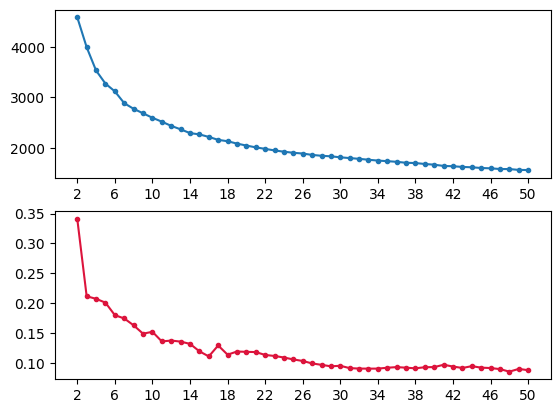

In [6]:
fig, (ax1, ax2) = plt.subplots(2) 

ax1.plot(np.arange(2,51), sse_list, marker='.')
ax1.set_xticks(np.arange(2,51,4))

ax2.plot(np.arange(2,51), sil_list, marker='.', color='crimson')
ax2.set_xticks(np.arange(2,51,4))

plt.savefig(fname='img/clustering_bkmeans_SSE_and_Silhouette.png', dpi=300, bbox_inches='tight')

plt.show()

k = 5 è l'iperparametro migliore come tradeoff tra SSE e silhouette coefficient (con k=6 non sono molto ben separati)

In [7]:
k = 5

In [8]:
bkmeans = BisectingKMeans(n_clusters=k, n_init=10, max_iter=100)
bkmeans.fit(X_minmax)

BisectingKMeans(max_iter=100, n_clusters=5, n_init=10)

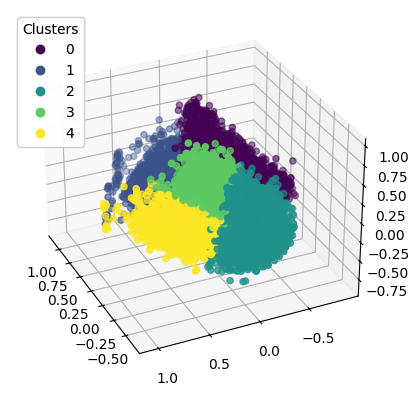

In [12]:
pca = PCA(n_components=3)  # Initialize a PCA model with 2 components
pca_data = pd.DataFrame(pca.fit_transform(X_minmax),columns=['PC1','PC2','PC3'])
pca_data['cluster'] = pd.Categorical(bkmeans.labels_)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(pca_data['PC1'],pca_data['PC2'],pca_data['PC3'],c=pca_data['cluster'])
ax.add_artist(ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters"))
ax.view_init(elev=30., azim=155)


plt.savefig(fname='img/PCA_biseckmeans.png', dpi=300, bbox_inches='tight')
plt.show()

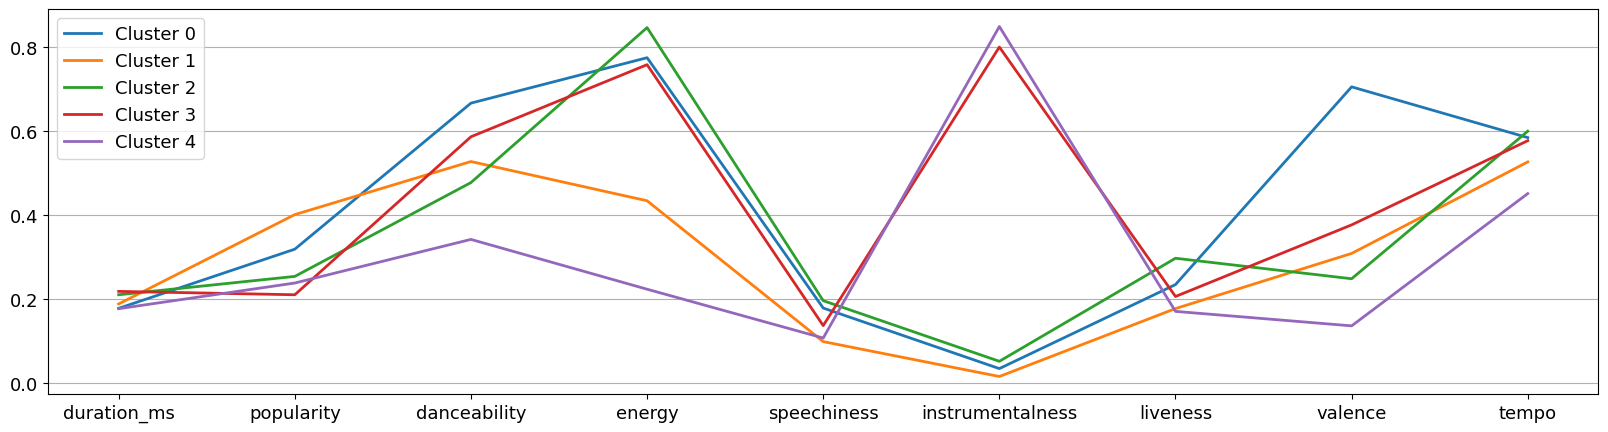

In [18]:
plt.figure(figsize=(20, 5))
centers = bkmeans.cluster_centers_
for i in range(len(centers)):
    plt.plot(range(0, 9), centers[i], label='Cluster %s' % i, linewidth=2)
    
plt.xticks(range(0,len(num)), num, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=13, loc='best')
plt.grid(axis='y')

plt.savefig(fname='img/biseckmeans_centroids.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Numero di punti per cluster

labels, counts = np.unique(bkmeans.labels_, return_counts=True)
for l, c in zip(labels,counts):
    print('Cluster ', l, ': ', c)
print('Silhouette: ', silhouette_score(X_minmax, bkmeans.labels_))
print('SSE: ', bkmeans.inertia_)

Cluster  0 :  3246
Cluster  1 :  1629
Cluster  2 :  5345
Cluster  3 :  1994
Cluster  4 :  2736
Silhouette:  0.20127728611215623
SSE:  3272.8812103406135


### X-means

In [47]:
# con un aggiornamento di numpy è stato rimosso l'alias numpy.warnings
# con queste due linee ci si mette sopra una pezza
import warnings
np.warnings = warnings

xm = xmeans.xmeans(X_minmax, kmax=6)
xm.process()

In [48]:
def clusters_to_labels(clusters):
    labels = np.empty(shape=(len(np.concatenate(clusters))), dtype=int)
    for i in range(len(clusters)):
        for idx in clusters[i]:
            labels[idx] = i
    return labels

In [49]:
clusters = xm.get_clusters()
labels = clusters_to_labels(clusters)

centers = np.array(xm.get_centers())

In [53]:
k = 6

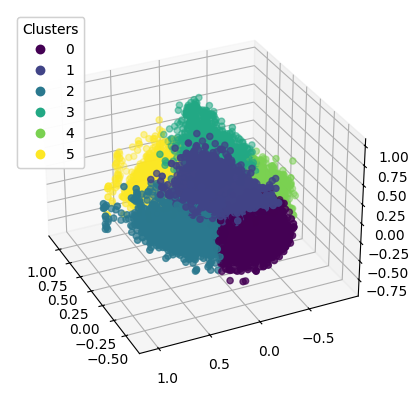

In [52]:
pca = PCA(n_components=3)  # Initialize a PCA model with 2 components
pca_data = pd.DataFrame(pca.fit_transform(X_minmax),columns=['PC1','PC2','PC3'])
pca_data['cluster'] = pd.Categorical(labels)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(pca_data['PC1'],pca_data['PC2'],pca_data['PC3'],c=pca_data['cluster'])
ax.add_artist(ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters"))
ax.view_init(elev=30., azim=155)


plt.savefig(fname='img/PCA_xmeans.png', dpi=300, bbox_inches='tight')
plt.show()

Risultato simile a kmeans se limitiamo il numero di cluster

In [51]:
# Numero di punti per cluster

labels_xm, counts = np.unique(labels, return_counts=True)
for l, c in zip(labels_xm,counts):
    print('Cluster ', l, ': ', c)
print('Silhouette: ', silhouette_score(X_minmax, labels))

Cluster  0 :  4514
Cluster  1 :  2520
Cluster  2 :  2981
Cluster  3 :  1762
Cluster  4 :  1553
Cluster  5 :  1620
Silhouette:  0.21024374617136785


# Analysis by density-based clustering

### DBSCAN

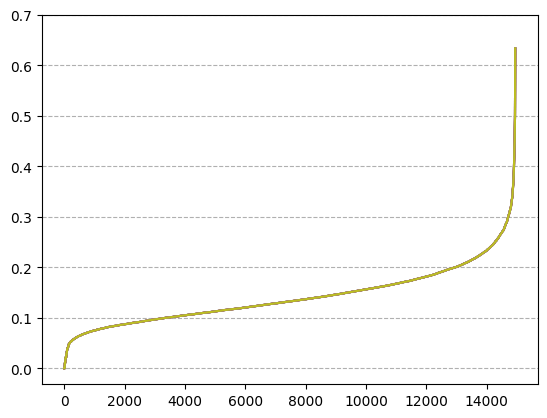

In [66]:
# controllo del miglior valore di eps con K-NN

for minpts in [2,4,8,16,32,64,128,256,512]:
    neighbors = NearestNeighbors(n_neighbors=minpts)
    neighbors_fit = neighbors.fit(X_minmax)
    
    dist, idx = neighbors_fit.kneighbors(X_minmax)
    
    # dist viene ordinato in base a n_neighbors
    dist = np.sort(dist, axis=0) 
    
    plt.plot(dist[:,1])
    
    plt.yticks(np.arange(stop=0.8, step=0.1))
    plt.grid(axis='y', linestyle='--')

#plt.savefig(fname='eps_knn.png', dpi=300, bbox_inches='tight')

plt.show()

In [5]:
eps = 0.24

In [6]:
minpts = 64

In [59]:
sil_list=[]
for minpts in [2,4,8,16,32,64,128,256,512]:
    dbscan = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
    dbscan.fit(X_minmax)

    try:
        sil = silhouette_score(X_minmax[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1])
        sil_list.append(sil)
    except:
        print('no clusters', minpts)

no clusters 256
no clusters 512


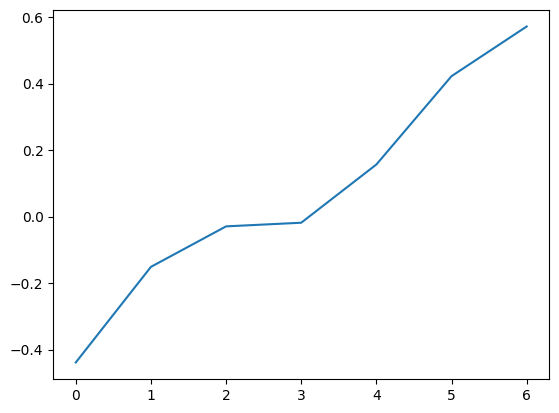

In [60]:
plt.plot(sil_list)

- minpts = 64
- Miglior valore di eps trovato: 0.24
- Silhouette coeff.: 0.4221279009298259

In [7]:
dbscan = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
dbscan.fit(X_minmax)

DBSCAN(eps=0.24, min_samples=64)

In [8]:
# Numero di punti per cluster

labels, counts = np.unique(dbscan.labels_, return_counts=True)
for l, c in zip(labels,counts):
    print('Cluster ', l, ': ', c)
print('Silhouette: ', silhouette_score(X_minmax[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]))

Cluster  -1 :  5846
Cluster  0 :  7071
Cluster  1 :  605
Cluster  2 :  1428
Silhouette:  0.4221279009298259


In [30]:
new_df = df[num]
new_df['dblabels'] = dbscan.labels_

/var/folders/dt/1fn71bpx79xgdp8ds17s_9f40000gn/T/ipykernel_44653/3898372016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['dblabels'] = dbscan.labels_


In [42]:
new_df[['instrumentalness','dblabels']].groupby('dblabels').mean()

,instrumentalness
dblabels,
-1,0.419780
0,0.012719
1,0.891969
2,0.846677


In [ ]:
sns.countplot(data=df[num], x='kmeans_labels', hue=df[num], order=["A", "B", "C"])
plt.show()

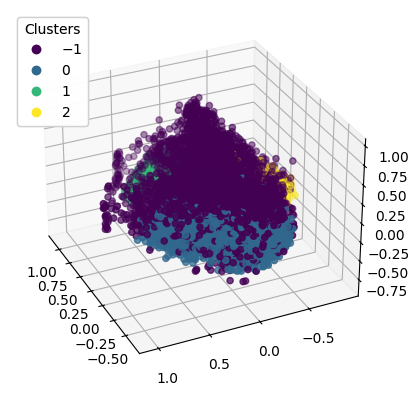

In [75]:
# pca = PCA(n_components=3)  # Initialize a PCA model with 2 components
pca_data = pd.DataFrame(pca.fit_transform(X_minmax),columns=['PC1','PC2','PC3'])
pca_data['cluster'] = pd.Categorical(dbscan.labels_)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(pca_data['PC1'],pca_data['PC2'],pca_data['PC3'],c=pca_data['cluster'])
ax.add_artist(ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters"))
ax.view_init(elev=30., azim=155)


plt.savefig(fname='img/PCA_DBSCAN.png', dpi=300, bbox_inches='tight')
plt.show()

### OPTICS

Eseguito con parametri uguali a prima

In [9]:
optics = OPTICS(min_samples=minpts, max_eps=np.inf, cluster_method='dbscan', eps=eps)
optics.fit(X_minmax)

OPTICS(cluster_method='dbscan', eps=0.24, min_samples=64)

Reachability plot prodotto da OPTICS

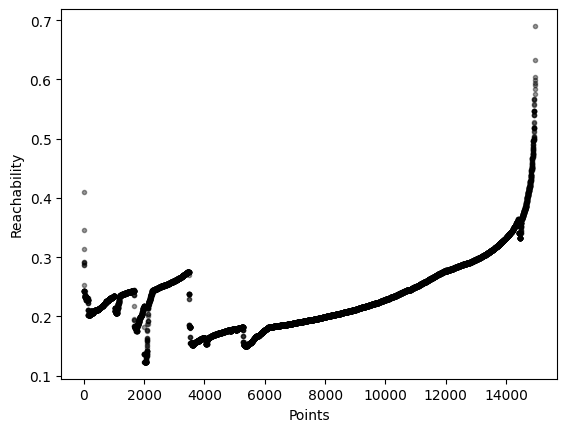

In [10]:
space = np.arange(len(X_minmax))
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]

plt.plot(space, reachability, "k.", alpha=0.4)
plt.xlabel("Points")
plt.ylabel("Reachability")

plt.savefig(fname='img/reachability_plot.png', dpi=300, bbox_inches='tight')

plt.show()

In [11]:
# Numero di punti per cluster

labels, counts = np.unique(optics.labels_, return_counts=True)
for l, c in zip(labels,counts):
    print('Cluster ', l, ': ', c)
print('Silhouette: ', silhouette_score(X_minmax[optics.labels_ != -1], optics.labels_[optics.labels_ != -1]))

Cluster  -1 :  5885
Cluster  0 :  1411
Cluster  1 :  587
Cluster  2 :  7067
Silhouette:  0.42335629622926835


In [ ]:
pca = PCA(n_components=3)  # Initialize a PCA model with 2 components
pca_data = pd.DataFrame(pca.fit_transform(X_minmax),columns=['PC1','PC2','PC3'])
pca_data['cluster'] = pd.Categorical(optics.labels_)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(pca_data['PC1'],pca_data['PC2'],pca_data['PC3'],c=pca_data['cluster'])
ax.add_artist(ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters"))
ax.view_init(elev=30., azim=155)


plt.savefig(fname='img/PCA_OPTICS.png', dpi=300, bbox_inches='tight')
plt.show()

Risultato molto simile a DBSCAN.

Ritentando con valore di minpts diverso per controllare se cambia il s.c.:

In [133]:
optics = OPTICS(min_samples=minpts*2, max_eps=np.inf, cluster_method='dbscan', eps=eps)
optics.fit(X_minmax)

OPTICS(cluster_method='dbscan', eps=0.321, min_samples=88)

In [ ]:
# Numero di punti per cluster

labels, counts = np.unique(optics.labels_, return_counts=True)
for l, c in zip(labels,counts):
    print('Cluster ', l, ': ', c)
print('Silhouette: ', silhouette_score(X_minmax[optics.labels_ != -1], optics.labels_[optics.labels_ != -1]))

In [ ]:
space = np.arange(len(X_minmax))
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]

plt.plot(space, reachability, "k.", alpha=0.4)
plt.xlabel("Points")
plt.ylabel("Reachability")

plt.show()

In [ ]:
sns.scatterplot(data=df, 
                x="instrumentalness", 
                y="energy", 
                hue=optics.labels_, 
                style=optics.labels_,
                palette="bright")
plt.show()

Il risultato è peggiore, quindi MinPts=42 va bene.

# Analysis by hierarchical clustering

In [46]:
def get_linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

### Complete link (MAX)

In [47]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='complete')
model = model.fit(X_minmax)

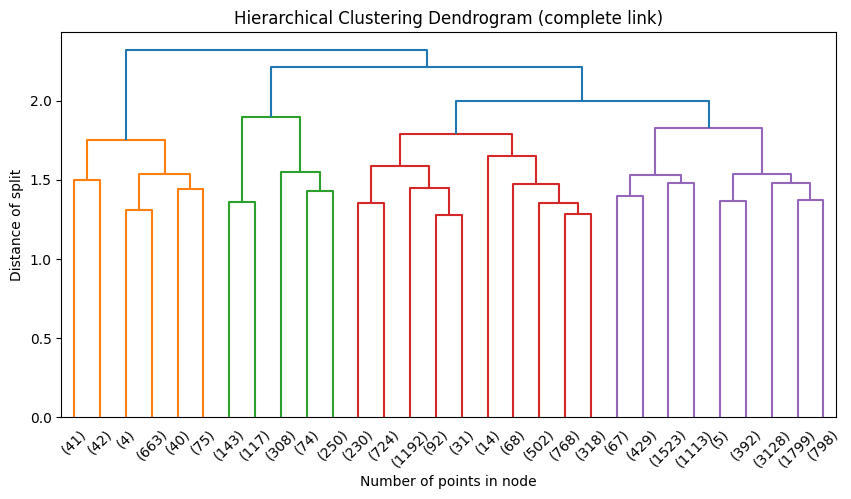

In [272]:
plt.figure(figsize=(10,5))
plt.title("Hierarchical Clustering Dendrogram (complete link)")
plot_dendrogram(model, truncate_mode="lastp", color_threshold=1.9)
plt.xlabel("Number of points in node")
plt.ylabel("Distance of split")

plt.savefig(fname='img/clustering_complete_link.png', dpi=300, bbox_inches='tight')

plt.show()

In [48]:
t = 1.9

In [49]:
Z = get_linkage_matrix(model)

labels = fcluster(Z, t=t, criterion='distance')
sil = silhouette_score(X_minmax, labels)

labels, counts = np.unique(labels, return_counts=True)
for l, c in zip(labels, counts):
    print('Cluster ', l, ': ', c)
print('Silhouette: ', sil)

Cluster  1 :  865
Cluster  2 :  892
Cluster  3 :  3939
Cluster  4 :  9254
Silhouette:  0.2673096739809739


In [55]:
from sklearn.neighbors import NearestCentroid

In [56]:
clf = NearestCentroid()
clf.fit(X_minmax, fcluster(Z, t=t, criterion='distance'))

NearestCentroid()

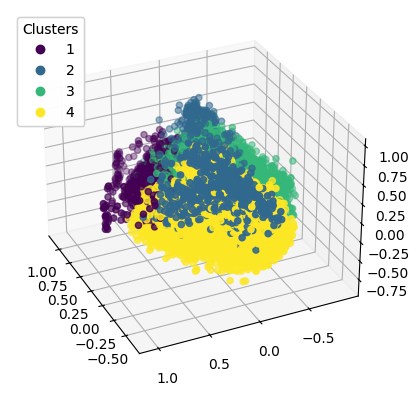

In [86]:
pca = PCA(n_components=3)  # Initialize a PCA model with 2 components
pca_data = pd.DataFrame(pca.fit_transform(X_minmax),columns=['PC1','PC2','PC3'])
pca_data['cluster'] = pd.Categorical(fcluster(Z, t=t, criterion='distance'))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(pca_data['PC1'],pca_data['PC2'],pca_data['PC3'],c=pca_data['cluster'])
ax.add_artist(ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters"))
ax.view_init(elev=30., azim=155)


plt.savefig(fname='img/PCA_hier_completelink.png', dpi=300, bbox_inches='tight')
plt.show()

### Single link (MIN)

In [87]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='single')
model = model.fit(X_minmax)

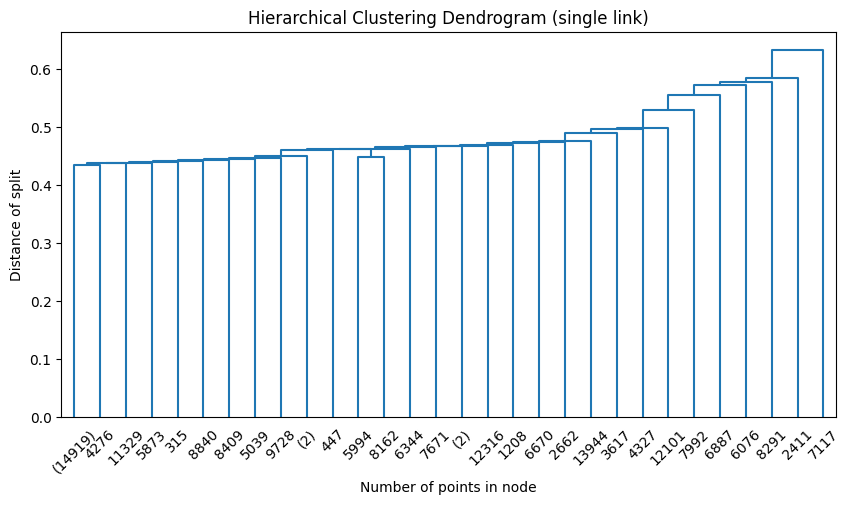

In [88]:
plt.figure(figsize=(10,5))

plt.title("Hierarchical Clustering Dendrogram (single link)")
plot_dendrogram(model, truncate_mode="lastp", color_threshold=0.0)
plt.xlabel("Number of points in node")
plt.ylabel("Distance of split")

plt.savefig(fname='img/clustering_single_link.png', dpi=300, bbox_inches='tight')

plt.show()

### Group average:

In [89]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='average')
model = model.fit(X_minmax)

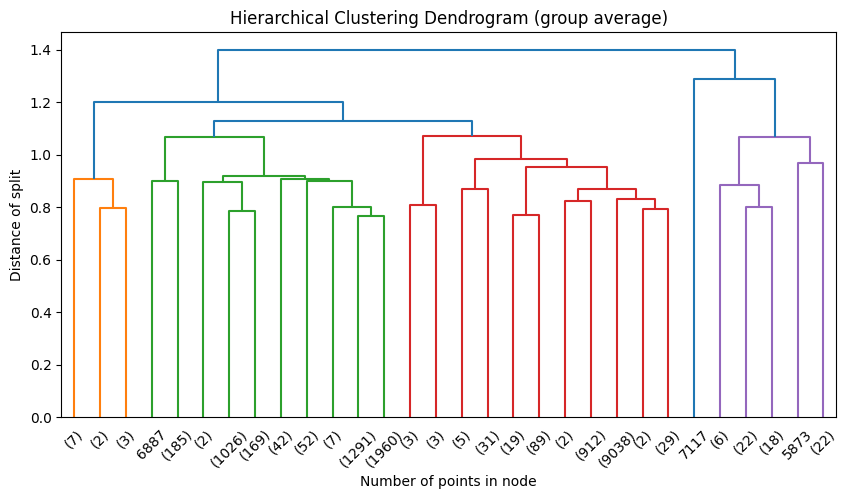

In [91]:
plt.figure(figsize=(10,5))

plt.title("Hierarchical Clustering Dendrogram (group average)")
plot_dendrogram(model, truncate_mode="lastp", color_threshold=1.1)
plt.xlabel("Number of points in node")
plt.ylabel("Distance of split")

plt.savefig(fname='img/clustering_group_average.png', dpi=300, bbox_inches='tight')

plt.show()

In [92]:
t = 1.1

In [93]:
Z = get_linkage_matrix(model)

labels = fcluster(Z, t=t, criterion='distance')
sil = silhouette_score(X_minmax, labels)

labels, counts = np.unique(labels, return_counts=True)
for l, c in zip(labels, counts):
    print('Cluster ', l, ': ', c)
print('Silhouette: ', sil)

Cluster  1 :  12
Cluster  2 :  4735
Cluster  3 :  10133
Cluster  4 :  69
Cluster  5 :  1
Silhouette:  0.3066752756688586


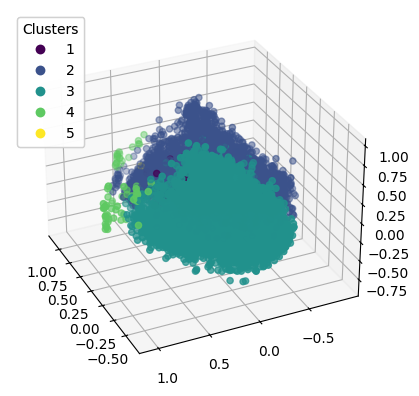

In [101]:
# pca = PCA(n_components=3)  # Initialize a PCA model with 2 components
pca_data = pd.DataFrame(pca.fit_transform(X_minmax),columns=['PC1','PC2','PC3'])
pca_data['cluster'] = pd.Categorical(fcluster(Z, t=t, criterion='distance'))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(pca_data['PC1'],pca_data['PC2'],pca_data['PC3'],c=pca_data['cluster'])
ax.add_artist(ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters"))
ax.view_init(elev=30., azim=155)


plt.savefig(fname='img/PCA_hier_groupavg.png', dpi=300, bbox_inches='tight')
plt.show()

### Metodo di Ward

In [62]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='ward')
model = model.fit(X_minmax)

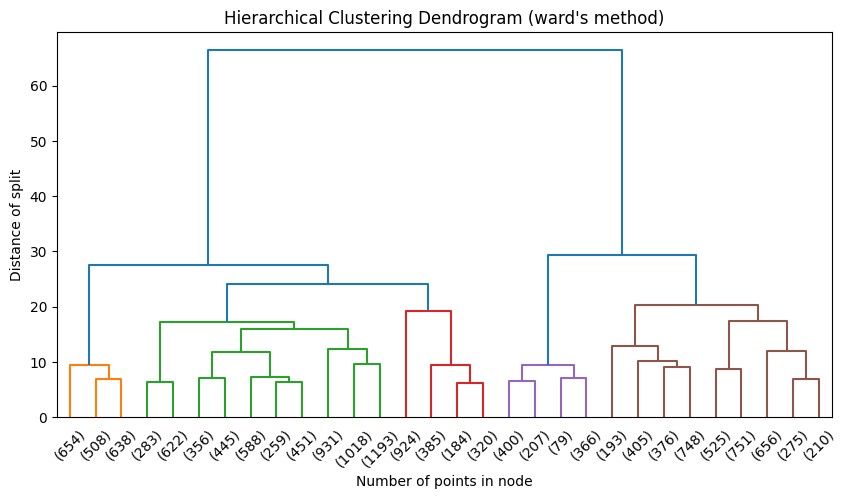

In [63]:
plt.figure(figsize=(10,5))

plt.title("Hierarchical Clustering Dendrogram (ward's method)")
plot_dendrogram(model, truncate_mode="lastp", color_threshold=22)
plt.xlabel("Number of points in node")
plt.ylabel("Distance of split")

plt.savefig(fname='img/clustering_wards_method.png', dpi=300, bbox_inches='tight')

plt.show()

In [64]:
t = 22

In [65]:
Z = get_linkage_matrix(model)

labels = fcluster(Z, t=t, criterion='distance')
sil = silhouette_score(X_minmax, labels)

labels, counts = np.unique(labels, return_counts=True)
for l, c in zip(labels, counts):
    print('Cluster ', l, ': ', c)
print('Silhouette: ', sil)

Cluster  1 :  1800
Cluster  2 :  6146
Cluster  3 :  1813
Cluster  4 :  1052
Cluster  5 :  4139
Silhouette:  0.170739726802687


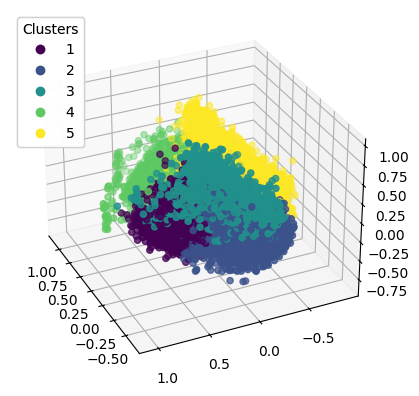

In [111]:
pca = PCA(n_components=3)  # Initialize a PCA model with 2 components
pca_data = pd.DataFrame(pca.fit_transform(X_minmax),columns=['PC1','PC2','PC3'])
pca_data['cluster'] = pd.Categorical(fcluster(Z, t=t, criterion='distance'))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(pca_data['PC1'],pca_data['PC2'],pca_data['PC3'],c=pca_data['cluster'])
ax.add_artist(ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters"))
ax.view_init(elev=30., azim=155)


plt.savefig(fname='img/PCA_hier_wardmethod.png', dpi=300, bbox_inches='tight')
plt.show()